<a href="https://colab.research.google.com/github/Aravindh4404/FYPSeagullClassification01/blob/main/OrigAdultResnet1210.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Set the data root directories
train_data_root = "/content/drive/My Drive/FYP/Dataset/Original_Adult/train"
test_data_root = "/content/drive/My Drive/FYP/Dataset/Original_Adult/test"  # New directory for the test set

# Image size for resizing
IMAGE_SHAPE = (224, 224)

# Create ImageDataGenerators with augmentation for training and simple scaling for test
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80-20 split for training and validation
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Define training and validation generators
train_generator = train_datagen.flow_from_directory(
    train_data_root,
    subset="training",
    shuffle=True,
    target_size=IMAGE_SHAPE,
    class_mode='categorical',
    batch_size=32
)

valid_generator = valid_datagen.flow_from_directory(
    train_data_root,
    subset="validation",
    shuffle=False,
    target_size=IMAGE_SHAPE,
    class_mode='categorical',
    batch_size=32
)

# Define test generator
test_generator = test_datagen.flow_from_directory(
    test_data_root,  # This is where your test data is located
    target_size=IMAGE_SHAPE,
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# Print class indices to understand label mapping
print("Class Indices:", train_generator.class_indices)


Mounted at /content/drive
Found 549 images belonging to 2 classes.
Found 136 images belonging to 2 classes.
Found 94 images belonging to 2 classes.
Class Indices: {'Glaucous_Winged_Gull': 0, 'Slaty_Backed_Gull': 1}


In [ ]:
# Define input shape
input_shape = (224, 224, 3)

# Load ResNet50 model with pre-trained ImageNet weights, exclude the top layer
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

# Freeze base model layers to prevent retraining
base_model.trainable = False

# Define the model
inputs = tf.keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)  # Dropout to avoid overfitting
outputs = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary for review
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
from datetime import datetime

# Get today's date in the format you prefer (e.g., YYYY-MM-DD)
today_date = datetime.now().strftime("%d%m")

# Define the paths with today's date for both checkpoint and final model
checkpoint_path = f'/content/drive/My Drive/FYP/MODELS/Original_Curated/Adult/resnet50_best_model_{today_date}.keras'
final_model_path = f'/content/drive/My Drive/FYP/MODELS/Original_Curated/Adult/resnet50_final_model_{today_date}.keras'

# Early stopping and checkpoint with .keras extension and today's date in the filename
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True)

# Train the model with train and validation data
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=40,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# Save the final model with today's date
model.save(final_model_path)

# Print the save paths to confirm
print(f"Best model saved as: {checkpoint_path}")
print(f"Final model saved as: {final_model_path}")


Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 209s 10s/step - accuracy: 0.4932 - loss: 1.0183 - val_accuracy: 0.4766 - val_loss: 0.7627
Epoch 2/40
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1:23 5s/step - accuracy: 0.4688 - loss: 0.8648

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.4688 - loss: 0.8648 - val_accuracy: 1.0000 - val_loss: 0.4485
Epoch 3/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 193s 8s/step - accuracy: 0.5045 - loss: 0.7704 - val_accuracy: 0.4766 - val_loss: 0.6932
Epoch 4/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.5312 - loss: 0.7413 - val_accuracy: 1.0000 - val_loss: 0.5497
Epoch 5/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 149s 9s/step - accuracy: 0.4690 - loss: 0.7637 - val_accuracy: 0.5938 - val_loss: 0.6806
Epoch 6/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.5312 - loss: 0.6982 - val_accuracy: 0.1250 - val_loss: 0.7686
Epoch 7/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 187s 8s/step - accuracy: 0.4900 - loss: 0.7379 - val_accuracy: 0.5312 - val_loss: 0.6848
Best model saved as: /content/drive/My Drive/FYP/MODELS/Original_Curated/Adult/resnet50_best_model_1210.keras
Final model saved as: /content/drive/My Drive/FYP/MODELS/Original_Curated/Adult/resnet50_final_model_1210.keras


3/3 - 20s - 7s/step - accuracy: 0.4894 - loss: 0.7361
Test Loss: 0.7361356019973755
Test Accuracy: 0.4893617033958435


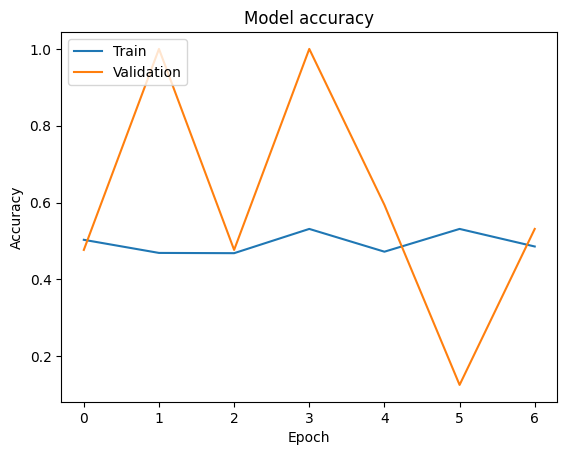

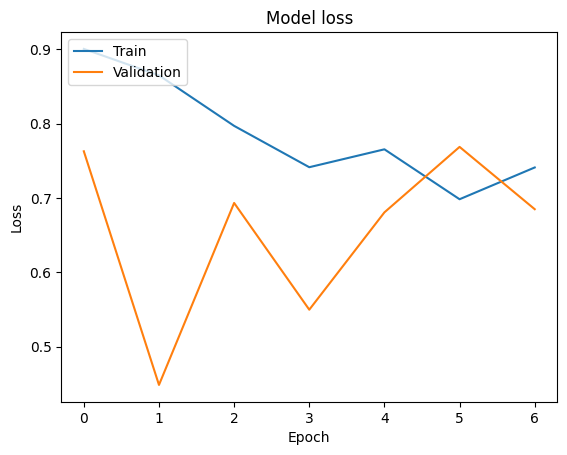

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Load and preprocess an image for prediction
img_path = '/content/1200 - 2024-08-18T191833.742.jpeg'
img = image.load_img(img_path, target_size=IMAGE_SHAPE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize the image

# Make prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Print the predicted class
print(f"Predicted class: {list(train_generator.class_indices.keys())[predicted_class[0]]}")
